In [1]:
import numpy as np
from math import sqrt, pi
import matplotlib.pyplot as plt

In [2]:
class ToyCar:
    def __init__(self, initialState=0):
        self.InitialState = initialState
        self.state = initialState; 
        self.goal  = 50; 
    def step(self, action):
        state_next = self.state + action
        if state_next < -50: #  if the agent tries to pass the border at the left, it stays at the border
            state_next = -50
        distance = self.goal - state_next
        reward = -1
        if distance < 0:
            done = True
        else:
            done = False
        self.state = state_next
        info = True # dummy assignment 
        return [state_next], reward, done, info # state is put into an array to be consistent with the convention of Mountain Car
    def reset(self):
        self.state = self.InitialState; 
        return [self.state]  # state is put into an array to be consistent with the convention of Mountain Car

In [3]:
env = ToyCar(initialState=0)
print(f'Goal of environment: {env.goal}')
print(f'Initial state of environment: {env.state}')

Goal of environment: 50
Initial state of environment: 0


In [4]:
print('Take action: 5')
state_next, reward, done, _ = env.step(5)
print(f'Next state of environment: {state_next[0]}')
print(f'Done: {done}')

print('\nTake action: -10')
state_next, reward, done, _ = env.step(-10)
print(f'Next state of environment: {state_next[0]}')
print(f'Done: {done}')


print('\nTake action: 156')
state_next, reward, done, _ = env.step(156)
print(f'Next state of environment: {state_next[0]}')
print(f'Done: {done}')

Take action: 5
Next state of environment: 5
Done: False

Take action: -10
Next state of environment: -5
Done: False

Take action: 156
Next state of environment: 151
Done: True


In [5]:
# One-step Actor-Critic with Gaussian parametrisation for estimating optimal policy
class ActorCritic:
    def __init__(self, gamma, alpha_theta, alpha_w):
        self.gamma = gamma
        self.alpha_theta = alpha_theta
        self.theta = [0, 1] # Initialisation of parameter theta = [theta_mean, theta_var]
        self.gamma_power = 1 
        self.alpha_w = alpha_w
        self.w = [0] # Initialisation of parameter w
    
    def mean_computation(self, state):
        theta_mean = self.theta[0]
        return np.dot(theta_mean, 1) # Feature = 1 is not dependent on the current agent state
    
    def variance_computation(self, state):
        theta_var = self.theta[1]
        return np.exp(np.dot(theta_var, 1)) # Feature = 1 is not dependent on the current agent state

    def act(self, state):
        mean = self.mean_computation(state)
        var = self.variance_computation(state)
        action = np.random.normal(mean, var) # Draw a random sample from the Gaussian distribution
        return action
        
    def valueFunc(self, state):
        return self.w[0] * state[0]

    def learn(self, state, action, state_next, reward, done):
        if done:
            value_next = 0 # If terminal state, set value function of state_next to 0
        else:
            value_next = self.valueFunc(state_next)
        delta = reward + self.gamma * value_next - self.valueFunc(state)
        self.w[0] = self.w[0] + self.alpha_w * delta * state[0]
        mean = self.mean_computation(state)
        var = self.variance_computation(state)
        gradient_theta = [(1 / (var**2 + 0.000001)) * (action - mean) * 1, (((action - mean)**2 / (var**2 + 0.000001)) - 1) * 1]
        self.theta = self.theta + np.dot((self.alpha_theta * self.gamma_power * delta), gradient_theta)
        self.gamma_power = self.gamma * self.gamma_power

In [6]:
def train_onestep(env, agent, nEpisode):
    total_reward_episodes = np.zeros(nEpisode)
    for episode in range(nEpisode):
        done = False
        state = env.reset()
        action = agent.act(state)
        actionA = [action]
        stateA = [state]
        rewardA = [0]
        while not done:
            state_past = state
            state, reward, done, _ = env.step(action)
            agent.learn(state_past, action, state, reward, done)
            rewardA.append(reward)
            stateA.append(state)
            action = agent.act(state)
            actionA.append(action)
        total_reward_episodes[episode] = np.sum(rewardA)
        if episode % 200 == 0: 
            print(f'Episode {episode}: {total_reward_episodes[episode]}')
    return total_reward_episodes

In [7]:
def plotRewards(rewards, lbl):
    plt.plot(rewards, label=lbl)
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.ylim(-100,4)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

In [8]:
env = ToyCar(initialState=0)
agent = ActorCritic(gamma=1, alpha_theta=2**(-13), alpha_w=2**(-11)) 
total_reward_episodes = train_onestep(env, agent, nEpisode=10000)

Episode 0: -608.0
Episode 200: -49.0
Episode 400: -99.0
Episode 600: -72.0
Episode 800: -23.0
Episode 1000: -3.0
Episode 1200: -54.0
Episode 1400: -17.0
Episode 1600: -7.0
Episode 1800: -9.0
Episode 2000: -22.0
Episode 2200: -3.0
Episode 2400: -15.0
Episode 2600: -8.0
Episode 2800: -3.0
Episode 3000: -1.0
Episode 3200: -1.0
Episode 3400: -9.0
Episode 3600: -1.0
Episode 3800: -3.0
Episode 4000: -1.0
Episode 4200: -8.0
Episode 4400: -2.0
Episode 4600: -1.0
Episode 4800: -18.0
Episode 5000: -4.0
Episode 5200: -4.0
Episode 5400: -4.0
Episode 5600: -3.0
Episode 5800: -1.0
Episode 6000: -1.0
Episode 6200: -2.0
Episode 6400: -3.0
Episode 6600: -1.0
Episode 6800: -2.0
Episode 7000: -2.0
Episode 7200: -1.0
Episode 7400: -3.0
Episode 7600: -1.0
Episode 7800: -10.0
Episode 8000: -2.0
Episode 8200: -4.0
Episode 8400: -12.0
Episode 8600: -1.0
Episode 8800: -10.0
Episode 9000: -5.0
Episode 9200: -10.0
Episode 9400: -1.0
Episode 9600: -5.0
Episode 9800: -1.0


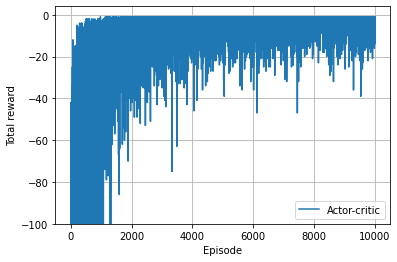

In [9]:
plotRewards(total_reward_episodes, lbl = 'Actor-critic')

In [10]:
episodes = 10000
average_reward_episodes = np.zeros(episodes)
number_runs = 10
for run in range(0,number_runs):
    env = ToyCar(initialState=0)
    agent = ActorCritic(gamma=1, alpha_theta=2**(-13), alpha_w=2**(-11)) 
    total_reward_episodes = train_onestep(env, agent, nEpisode=episodes)
    average_reward_episodes = average_reward_episodes + total_reward_episodes
average_reward_episodes = average_reward_episodes / number_runs

Episode 0: -490.0
Episode 200: -10.0
Episode 400: -86.0
Episode 600: -42.0
Episode 800: -3.0
Episode 1000: -19.0
Episode 1200: -15.0
Episode 1400: -16.0
Episode 1600: -9.0
Episode 1800: -2.0
Episode 2000: -24.0
Episode 2200: -7.0
Episode 2400: -3.0
Episode 2600: -8.0
Episode 2800: -19.0
Episode 3000: -9.0
Episode 3200: -22.0
Episode 3400: -1.0
Episode 3600: -7.0
Episode 3800: -14.0
Episode 4000: -9.0
Episode 4200: -4.0
Episode 4400: -1.0
Episode 4600: -2.0
Episode 4800: -5.0
Episode 5000: -15.0
Episode 5200: -1.0
Episode 5400: -2.0
Episode 5600: -4.0
Episode 5800: -8.0
Episode 6000: -11.0
Episode 6200: -18.0
Episode 6400: -2.0
Episode 6600: -2.0
Episode 6800: -1.0
Episode 7000: -6.0
Episode 7200: -2.0
Episode 7400: -7.0
Episode 7600: -3.0
Episode 7800: -1.0
Episode 8000: -1.0
Episode 8200: -1.0
Episode 8400: -6.0
Episode 8600: -1.0
Episode 8800: -1.0
Episode 9000: -2.0
Episode 9200: -1.0
Episode 9400: -3.0
Episode 9600: -1.0
Episode 9800: -8.0
Episode 0: -362.0
Episode 200: -29.0
Episo

Episode 6000: -6.0
Episode 6200: -4.0
Episode 6400: -4.0
Episode 6600: -2.0
Episode 6800: -5.0
Episode 7000: -3.0
Episode 7200: -3.0
Episode 7400: -1.0
Episode 7600: -3.0
Episode 7800: -2.0
Episode 8000: -2.0
Episode 8200: -3.0
Episode 8400: -2.0
Episode 8600: -17.0
Episode 8800: -8.0
Episode 9000: -1.0
Episode 9200: -1.0
Episode 9400: -3.0
Episode 9600: -1.0
Episode 9800: -1.0
Episode 0: -299.0
Episode 200: -72.0
Episode 400: -194.0
Episode 600: -27.0
Episode 800: -80.0
Episode 1000: -71.0
Episode 1200: -88.0
Episode 1400: -3.0
Episode 1600: -2.0
Episode 1800: -2.0
Episode 2000: -22.0
Episode 2200: -1.0
Episode 2400: -2.0
Episode 2600: -10.0
Episode 2800: -8.0
Episode 3000: -14.0
Episode 3200: -7.0
Episode 3400: -2.0
Episode 3600: -1.0
Episode 3800: -4.0
Episode 4000: -1.0
Episode 4200: -1.0
Episode 4400: -1.0
Episode 4600: -2.0
Episode 4800: -3.0
Episode 5000: -5.0
Episode 5200: -7.0
Episode 5400: -46.0
Episode 5600: -2.0
Episode 5800: -10.0
Episode 6000: -6.0
Episode 6200: -1.0
Epis

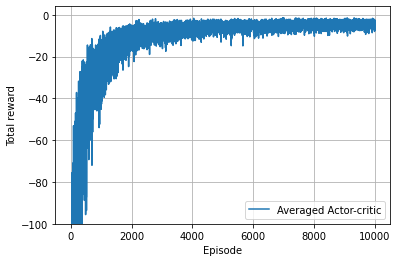

In [11]:
plotRewards(average_reward_episodes, lbl = 'Averaged Actor-critic')